# Loading train set 


In [1]:
import numpy as np
import pandas as pd
df_train = pd.read_csv('C:/Users/User/PycharmProjects/Earthquake/Student Hiring Project 2017 - Training Data.txt', header=None)

# Loading test set 

In [2]:

df_test = pd.read_csv('C:/Users/User/PycharmProjects/Earthquake/Student Hiring Project 2017 - Testing Data.txt', header=None)
# Assuming 'df' is your DataFrame and the last column is the label
X_test_set = df_test.iloc[:, :-1]  # exclude the label column
y_test_set = df_test.iloc[:, -1]

# Visualization of Data

In [3]:
for i, row in df_train.iterrows():
    # Checking if any feature in the row is 5 or above and the last column (label) is 1
    if np.any(row[:-1] >= 5) and row.iloc[-1] == 1:
        print(f"row {i} doesn't fulfill the requirement")

row 24 doesn't fulfill the requirement


## Getting rid of index 24
###This index doesn't fulfill the requirment that a major event occurence over the last 512 hours was labeled 1 

In [4]:
# Dropping the index which doesn't meet the criterion
df_train = df_train.drop(index=24)


# Visualizing the classes distribution

In [5]:
# Separating majority and minority classes
df_majority = df_train[df_train.iloc[:, -1] == 0]  # Assuming the last column is the target
df_minority = df_train[df_train.iloc[:, -1] == 1]

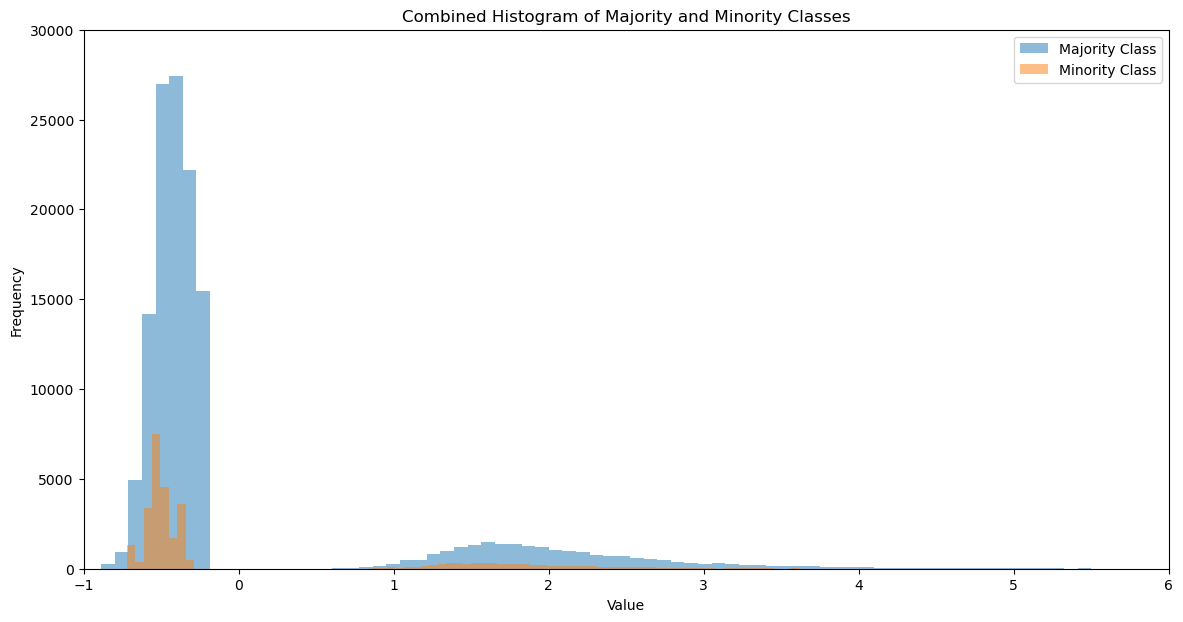

In [6]:
import matplotlib.pyplot as plt

# Flatten the data
flattened_majority = df_majority.iloc[:, :-1].values.flatten()
flattened_minority = df_minority.iloc[:, :-1].values.flatten()

# Plot histograms
plt.figure(figsize=(14, 7))

# Majority histogram
plt.hist(flattened_majority, bins=100, alpha=0.5, label='Majority Class')

# Minority histogram
plt.hist(flattened_minority, bins=100, alpha=0.5, label='Minority Class')

plt.title('Combined Histogram of Majority and Minority Classes')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.xlim(-1, 6)
plt.ylim(0, 30000)

plt.show()


In [7]:
# Count the number of occurrences for each class in the last column (target column)
class_counts = df_train.iloc[:, -1].value_counts()

# Display the counts
print(class_counts)


512
0    264
1     57
Name: count, dtype: int64


## Testing different models with CV to check for general compatibility with the data 

In [8]:
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
import pandas as pd
import warnings
from sklearn.exceptions import UndefinedMetricWarning

# Suppress UndefinedMetricWarnings
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

X_train_set = df_train.iloc[:, :-1]
y_train_set = df_train.iloc[:, -1]

# Define a dictionary of models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(),
    'Neural Network': MLPClassifier(random_state=42),
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression()
}

# Choose KFold or StratifiedKFold based on the balance of the dataset
cv = KFold(n_splits=10, shuffle=True, random_state=42)  

# Iterating over models and perform cross-validation
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    class_1_f1_scores = []

    # Use cross-validation
    all_reports = []
    for train_index, test_index in cv.split(X_train_set, y_train_set):
        X_train, X_test = X_train_set.iloc[train_index], X_train_set.iloc[test_index]
        y_train, y_test = y_train_set.iloc[train_index], y_train_set.iloc[test_index]

        # Create a pipeline with scaler and model
        pipeline = make_pipeline(StandardScaler(), model)

        # Train the model on the training fold
        pipeline.fit(X_train, y_train)

        # Make predictions on the testing fold
        y_pred = pipeline.predict(X_test)

        # Generate classification report for each fold and store it
        report = classification_report(y_test, y_pred, output_dict=True)
        # all_reports.append(report)
        class_1_f1 = report['1']['f1-score']
        class_1_f1_scores.append(class_1_f1)

    average_f1 = np.mean(class_1_f1_scores)
    print(f"{model_name} - Average F1-Score for Class 1: {average_f1:.2f}")



Evaluating Random Forest...
Random Forest - Average F1-Score for Class 1: 0.00
Evaluating Gradient Boosting...
Gradient Boosting - Average F1-Score for Class 1: 0.08
Evaluating SVM...
SVM - Average F1-Score for Class 1: 0.00
Evaluating Neural Network...
Neural Network - Average F1-Score for Class 1: 0.17
Evaluating Naive Bayes...
Naive Bayes - Average F1-Score for Class 1: 0.20
Evaluating Logistic Regression...
Logistic Regression - Average F1-Score for Class 1: 0.10


#### Although naive bayes is a simplistic model, it fits well with our data

# LSTM 
#### LSTM is a model that learns patterns of sequences in the model. That might be relevant in our case.

In [12]:
from keras.layers import LSTM, Dense
from keras import Sequential
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report
from scikeras.wrappers import KerasClassifier
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

# Split data into features and labels
X_train_set = df_train.iloc[:, :-1]  
y_train_set = df_train.iloc[:, -1]  

def create_lstm_model():
    # ... LSTM model definition ...
    model = Sequential()
    model.add(LSTM(50, input_shape=(512, 1)))  # Adjust according to your LSTM's expected input
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap the Keras model with KerasClassifier
# from keras.wrappers.scikit_learn import KerasClassifier
lstm_model = KerasClassifier(model=create_lstm_model, epochs=10, batch_size=32, verbose=0)

X_raw_scaled_reshaped = X_train_set.values.reshape((X_train_set.values.shape[0], X_train_set.values.shape[1], 1))


# Generate out-of-fold predictions for LSTM; you may need to modify the X data to match LSTM input shape
lstm_oof_pred = cross_val_predict(lstm_model, X_raw_scaled_reshaped, y_train_set, cv=cv, method='predict_proba')
for i, row in X_train_set.iterrows():
    # if i == 322:
    #     break
    if np.any(row[1:] >= 5):  # If any feature in the row is 5 or above
        lstm_oof_pred[i] = [0]  # Set the probability to [1, 0] for class 0
        
lstm_oof_class_pred = (lstm_oof_pred[:, 1] > 0.5).astype(int)  # Assuming the second column for the positive class

# Now generate the classification report
report = classification_report(y_train_set, lstm_oof_class_pred)
print(report)

              precision    recall  f1-score   support

           0       0.82      1.00      0.90       264
           1       0.50      0.02      0.03        57

    accuracy                           0.82       321
   macro avg       0.66      0.51      0.47       321
weighted avg       0.77      0.82      0.75       321


#### We can see that LSTM doesn't fit our data

# Featuring the train set

In [13]:
# Calculate the desired statistics directly from X_train_set
min_vals = X_train_set.min(axis=1)
max_vals = X_train_set.max(axis=1)
mean_vals = X_train_set.mean(axis=1)
std_vals = X_train_set.std(axis=1)

# Correcting the DataFrame used for skew, kurtosis, and percentiles
skew_vals = X_train_set.skew(axis=1)
kurt_vals = X_train_set.kurtosis(axis=1)
percentile25_vals = X_train_set.quantile(0.25, axis=1)
percentile50_vals = X_train_set.quantile(0.50, axis=1)  # This is the median
percentile75_vals = X_train_set.quantile(0.75, axis=1)
range_vals = max_vals - min_vals

# Create a new DataFrame with these features
df_train_featured = pd.DataFrame({
    'min': min_vals,
    'max': max_vals,
    'mean': mean_vals,
    'std': std_vals,
    'skew': skew_vals,
    'kurtosis': kurt_vals,
    'percentile25': percentile25_vals,
    'median': percentile50_vals,
    'percentile75': percentile75_vals,
    'range': range_vals,
    'label': df_train.iloc[:, -1]  # Assuming df_train is the correct DataFrame for labels
})

# Handling NaN values
df_train_featured['skew'] = df_train_featured['skew'].fillna(df_train_featured['skew'].median())
df_train_featured['kurtosis'] = df_train_featured['kurtosis'].fillna(df_train_featured['kurtosis'].median())
df_train_featured['percentile25'] = df_train_featured['percentile25'].fillna(df_train_featured['percentile25'].median())
df_train_featured['median'] = df_train_featured['median'].fillna(df_train_featured['median'].median())
df_train_featured['percentile75'] = df_train_featured['percentile75'].fillna(df_train_featured['percentile75'].median())

# Preparing features and labels for use
X_train_featured = df_train_featured.iloc[:, :-1]
y_train_set = df_train_featured.iloc[:, -1]


## Featuring the test set

In [14]:
# Calculate the desired statistics directly from X_test_set
min_vals = X_test_set.min(axis=1)
max_vals = X_test_set.max(axis=1)
mean_vals = X_test_set.mean(axis=1)
std_vals = X_test_set.std(axis=1)

# Correcting the DataFrame used for skew, kurtosis, and percentiles
skew_vals = X_test_set.skew(axis=1)
kurt_vals = X_test_set.kurtosis(axis=1)
percentile25_vals = X_test_set.quantile(0.25, axis=1)
percentile50_vals = X_test_set.quantile(0.50, axis=1)  # This is the median
percentile75_vals = X_test_set.quantile(0.75, axis=1)
range_vals = max_vals - min_vals

# Create a new DataFrame with these features
df_test_featured = pd.DataFrame({
    'min': min_vals,
    'max': max_vals,
    'mean': mean_vals,
    'std': std_vals,
    'skew': skew_vals,
    'kurtosis': kurt_vals,
    'percentile25': percentile25_vals,
    'median': percentile50_vals,
    'percentile75': percentile75_vals,
    'range': range_vals,
    'label': df_test.iloc[:, -1]  # Assuming df_test is the correct DataFrame for labels
})

# Handling NaN values
df_test_featured['skew'] = df_test_featured['skew'].fillna(df_test_featured['skew'].median())
df_test_featured['kurtosis'] = df_test_featured['kurtosis'].fillna(df_test_featured['kurtosis'].median())
df_test_featured['percentile25'] = df_test_featured['percentile25'].fillna(df_test_featured['percentile25'].median())
df_test_featured['median'] = df_test_featured['median'].fillna(df_test_featured['median'].median())
df_test_featured['percentile75'] = df_test_featured['percentile75'].fillna(df_test_featured['percentile75'].median())

# Preparing features and labels for use
X_test_featured = df_test_featured.iloc[:, :-1]
y_test_set = df_test_featured.iloc[:, -1]


## Checking the metrics on the test set

In [15]:

nb_model = GaussianNB()
nb_model.fit(X_train_featured, y_train_set)

nb_test_pred = nb_model.predict(X_test_featured)

print(classification_report(y_test_set, nb_test_pred))


              precision    recall  f1-score   support

           0       0.91      0.38      0.54       104
           1       0.33      0.89      0.48        35

    accuracy                           0.51       139
   macro avg       0.62      0.64      0.51       139
weighted avg       0.76      0.51      0.52       139


## Comparing to a dummy classifier

In [16]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="most_frequent")  # predicting only 0
dummy.fit(X_train_featured, y_train_set)

y_pred = dummy.predict(X_test_featured)

print(classification_report(y_test_set, y_pred))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86       104
           1       0.00      0.00      0.00        35

    accuracy                           0.75       139
   macro avg       0.37      0.50      0.43       139
weighted avg       0.56      0.75      0.64       139
